In [ ]:
import dask
dask.config.set({"dataframe.query-planning": False})

import re
import anndata
import scanpy as sc
import scipy
import numpy as np
import pandas as pd
import sys
import gc
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from typing import Dict, List

sys.path.append("../../../workflow/scripts/")
import _utils
import readwrite
cfg = readwrite.config()
sns.set_style('ticks')


def process_count_correction_samples_out_of_core(xenium_paths,correction_methods,func):
    """
    Reads corrected count samples in parallel using ThreadPoolExecutor.

    Args:
        xenium_paths (dict): A dictionary where keys are correction methods and values are dictionaries
                            mapping sample names to corrected counts file paths.  Assumes `xenium_paths[correction_method]`
                            is a dictionary with keys as sample name and values as path to the .h5 file.
        correction_methods (list): A list of correction methods.
        func: A function to apply to each sample
    Returns:
        dict: A dictionary where keys are correction methods, and values are dictionaries mapping sample names
              to AnnData objects (or None if reading failed).
    """

    xenium_corrected_counts = {}

    for correction_method in correction_methods:  # Skip the first correction method
        xenium_corrected_counts[correction_method] = {}

        with ThreadPoolExecutor() as executor:
            futures = {
                executor.submit(readwrite._read_count_correction_sample, k, xenium_corr_path): (correction_method, k)
                for k, xenium_corr_path in xenium_paths[correction_method].items()
            }

            # Progress bar with total number of samples
            for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {correction_method}"):
                try:
                    k, adata = future.result()
                    if adata is not None:
                        # fix raw obs names for proseg
                        if correction_method == 'raw' and k[0] == "proseg_expected": 
                            adata.obs_names = "proseg-" + adata.obs_names.astype(str)

                        # compute func
                        xenium_corrected_counts[correction_method][k] = func(adata)

                        # free memory
                        del adata
                        gc.collect()
                    else:
                         xenium_corrected_counts[correction_method][k] = None
                except Exception as e:
                    correction_method, k = futures[future]
                    xenium_corrected_counts[correction_method][k] = None  # Store None in case of error

    return xenium_corrected_counts



def get_mean_n_genes(
    ads: Dict[str, Dict[str, anndata.AnnData]],
    correction_methods: List[str],
    labels_key: str,
    columns=None
) -> pd.DataFrame:
    """
    Calculates the mean number of genes (`n_genes`) for all unique cell types (`cti`) found
    in the `labels_key` column across different AnnData objects and correction methods.

    Args:
        ads (Dict[str, Dict[str, anndata.AnnData]]): A nested dictionary structure containing
            AnnData objects. The outer dictionary's keys are correction methods, and the
            inner dictionary's keys are sample identifiers. Each inner dictionary value
            is an AnnData object. Assumes `ads[correction_method][k]` is an AnnData object.
        correction_methods (List[str]): A list of correction methods to iterate through.
        labels_key (str): The key in `ad.obs` that contains cell type labels.
        columns (list): optional column names for the returned DataFrame
    Returns:
        pd.DataFrame: A DataFrame where each row represents a unique combination of sample
            identifier, correction method, and cell type. The columns include sample identifiers,
            correction method, cell type (`cti`), and the calculated mean number of genes
            ('n_genes').
    """

    data = []
    for correction_method in correction_methods:
        for k, ad in ads[correction_method].items():
            if ad is not None:
                # Get unique cell types for the current AnnData object
                ad.obs['n_genes'] = (ad.X>0).sum(1).A1
                unique_ctis = ad.obs[labels_key].unique()

                for cti in unique_ctis:
                    mean_n_genes = np.mean(ad[ad.obs[labels_key] == cti].obs['n_genes'])
                    data.append((*k, correction_method, cti, mean_n_genes))  # Append cell type to the data

    # Create the DataFrame from the collected data
    df = pd.DataFrame(data, columns=columns)

    if columns is not None:
        df.columns = columns
    return df


# Params

In [7]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_count_correction_dir = Path(cfg['xenium_count_correction_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])
std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
scrnaseq_processed_data_dir = Path(cfg['scrnaseq_processed_data_dir'])
seurat_to_h5_dir = results_dir / 'seurat_to_h5'

# Params
signal_integrity_thresholds = [0.5, 0.7]
correction_methods = ['raw', 'split_fully_purified', 'resolvi', 'resolvi_supervised']
correction_methods += [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]
num_samples = 30
mixture_k = 50
normalisation = 'lognorm'
layer = 'data'
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'
count_correction_palette = palette_dir / 'col_palette_correction_method.csv'

radius = 10
n_permutations = 30
n_repeats = 5
top_n = 20
scoring = 'f1'
markers_mode = 'diffexpr'

xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
order = ['breast','chuvio','lung','5k']


hue_segmentation = "segmentation"
hue_segmentation_order = [
    "10x_mm_0um",
    "10x_mm_5um",
    "10x_mm_15um",
    "10x_0um",
    "10x_5um",
    "10x_15um",
    "baysor",
    "proseg_expected",
    "proseg_mode",
    "segger",
]

hue_correction = 'correction_method'
hue_correction_order = [
    'raw',
    'ResolVI',
    'ResolVI supervised',
    'ovrlpy 0.5',
    'ovrlpy 0.7',
    'SPLIT',
]


rank_metrics = ["logfoldchanges", "-log10pvals_x_logfoldchanges", "-log10pvals_x_sign_logfoldchanges","mean_zscore"]
plot_metrics = ['hypergeometric_pvalue','NES',f"n_hits_{top_n=}","mean_zscore_pvalue"]

labels_key = level

# Load results diffexpr

In [3]:
dfs = readwrite.read_contamination_metrics_results(
    results_dir,
    correction_methods,
    xenium_std_seurat_analysis_dir,
    reference,
    method,
    level,
    mixture_k,
    num_samples,
    normalisation,
    layer,
    markers_mode=markers_mode,
    radius=radius,
    n_permutations=n_permutations,
    n_repeats=n_repeats,
    top_n=top_n,
    scoring=scoring,
    evaluation='diffexpr'
)

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/split_fully_purified/proseg_expected/NSCLC/chuvio/1GA2/1GA2/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/single_cell/split_fully_purified/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/split_fully_purified/proseg_expected/NSCLC/chuvio/1GA2/1GA2/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/single_cell/split_fully_purified/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_di

Processing futures:  22%|██▏       | 330/1506 [00:00<00:00, 2737.02it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/split_fully_purified/10x_5um/NSCLC/chuvio/1GA2/1GA2/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/single_cell/split_fully_purified/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/split_fully_purified/10x_5um/NSCLC/chuvio/1GA2/1GA2/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/single_cell/split_fully_purified/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10

Processing futures:  68%|██████▊   | 1017/1506 [00:44<00:14, 33.83it/s] 

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/proseg_expected/NSCLC/5k/0PSV/0PSV/lognor

Processing futures:  70%|██████▉   | 1054/1506 [00:45<00:16, 27.59it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_co

Processing futures:  73%|███████▎  | 1095/1506 [00:47<00:12, 32.87it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_5um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference

Processing futures:  76%|███████▌  | 1148/1506 [00:49<00:07, 45.07it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_15um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_refere

Processing futures:  79%|███████▊  | 1184/1506 [00:51<00:08, 35.90it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GDD/1GDD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/baysor/NSCLC/5k/1GDD/1GDD/lognorm/data_matched_reference_combo_rctd_class_aware_L

Processing futures:  82%|████████▏ | 1229/1506 [00:53<00:08, 33.10it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.5/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference

Processing futures:  84%|████████▍ | 1269/1506 [00:55<00:07, 31.78it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/proseg_expected/NSCLC/5k/0PSV/0PSV/lognor

Processing futures:  87%|████████▋ | 1309/1506 [00:56<00:06, 31.13it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_co

Processing futures:  90%|████████▉ | 1351/1506 [00:58<00:04, 31.73it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1G73/1G73/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1G73/1G73/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference

Processing futures:  92%|█████████▏| 1383/1506 [01:00<00:05, 22.80it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_refere

Processing futures:  95%|█████████▌| 1436/1506 [01:02<00:02, 25.82it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/baysor/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_co

Processing futures:  98%|█████████▊| 1478/1506 [01:03<00:00, 39.02it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_marker_genes.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=10_n_permutations=30_n_repeats=5_top_n=20_f1_corrected_counts/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference

Processing futures: 100%|██████████| 1506/1506 [01:04<00:00, 23.19it/s]


# Load corrected counts

In [ ]:
xenium_paths = {}
xenium_annot_paths = {}

for correction_method in correction_methods:
    xenium_paths[correction_method] = {}
    xenium_annot_paths[correction_method] = {}
    
    for segmentation in (segmentations := xenium_std_seurat_analysis_dir.iterdir()):
        if segmentation.stem == 'proseg_mode':
            continue
        for condition in (conditions := segmentation.iterdir()): 
            for panel in (panels := condition.iterdir()):
                for donor in (donors := panel.iterdir()):
                    for sample in (samples := donor.iterdir()):

                        k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                        name = '/'.join(k)

                        # raw samples
                        if 'proseg' in segmentation.stem:
                            k_proseg = ('proseg',condition.stem,panel.stem,donor.stem,sample.stem)
                            name_proseg = '/'.join(k_proseg)
                            sample_dir = xenium_dir / f'{name_proseg}/raw_results'
                        else:
                            sample_dir = xenium_dir / f'{name}/normalised_results/outs'

                        sample_annotation = xenium_cell_type_annotation_dir / f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/labels.parquet'
                        
                        if correction_method == 'raw':
                            xenium_paths[correction_method][k] = sample_dir
                            xenium_annot_paths[correction_method][k] = sample_annotation
                        
                        # corrected samples
                        else:
                            if correction_method == "split_fully_purified":
                                name_corrected = f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/split_fully_purified/'
                                sample_corrected_counts_path = xenium_count_correction_dir / f"{name_corrected}/corrected_counts.h5"

                            else:
                                if correction_method == "resolvi":
                                    name_corrected = f'{name}/{mixture_k=}/{num_samples=}/'
                                elif correction_method == "resolvi_supervised":
                                    name_corrected = f'{name}/{normalisation}/reference_based/{reference}/{method}/{level}/{mixture_k=}/{num_samples=}'
                                elif "ovrlpy" in correction_method:
                                    name_corrected = f'{name}'

                                sample_corrected_counts_path = results_dir / f"{correction_method}/{name_corrected}/corrected_counts.h5"
                            sample_normalised_counts = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/{layer}.parquet'
                            sample_idx = xenium_std_seurat_analysis_dir / f'{name}/{normalisation}/normalised_counts/cells.parquet'

                            xenium_paths[correction_method][k] = sample_corrected_counts_path


ads = readwrite.read_count_correction_samples(xenium_paths,correction_methods[1:])
ads['raw'] = readwrite.read_xenium_samples(xenium_paths['raw'],anndata=True,transcripts=False,max_workers=6)

# fix obs names for proseg expected, load cell types
# filter out cells without labels (this will apply QC thresholds as well since annotation is done after QC)
pbs_xenium = {}
for correction_method in correction_methods:
    pbs_xenium[correction_method] = {}

    for k, ad in ads[correction_method].items():
        if ad is not None:

            if correction_method == 'raw':
                if k[0] == "proseg_expected": 
                    ad.obs_names = ad.obs_names.astype(str)
                    ad.obs_names = "proseg-" + ad.obs_names

                # filter cells and read labels for raw
                ad.obs[labels_key] = pd.read_parquet(xenium_annot_paths['raw'][k]).set_index("cell_id").iloc[:, 0]
                

                ad = ad[ad.obs[labels_key].notna()]
                if labels_key == "Level2.1":
                    # for custom Level2.1, simplify subtypes
                    ad.obs.loc[ad.obs[labels_key].str.contains("malignant"), labels_key] = "malignant cell"
                    ad.obs.loc[ad.obs[labels_key].str.contains("T cell"), labels_key] = "T cell"     
                    
                # remove tissue from cell type name
                ad.obs[labels_key] = ad.obs[labels_key].str.replace(r" of .+", "", regex=True)
                
                ads['raw'][k] = ad

            # filter cells and add labels from raw
            if correction_method != 'raw':
                ad.obs[labels_key] = ads['raw'][k].obs[labels_key]
                ad = ad[[c for c in ads['raw'][k].obs_names if c in ad.obs_names]]
                ads[correction_method][k] = ad

            pbs_xenium[correction_method][k] = _utils.pseudobulk(ads[correction_method][k],labels_key)
            sc.pp.normalize_total(pbs_xenium[correction_method][k])
            sc.pp.log1p(pbs_xenium[correction_method][k])

# Load scRNA

In [ ]:
layer = 'RNA_counts'
genes = {}
# use lung panel genes for both
genes['NSCLC'] = pd.read_csv('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
genes['breast'] = pd.read_csv('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/Xenium_hLung_v1_metadata.csv')['Gene'].tolist()

pbs_scrna = {}
for ref in (refs := scrnaseq_processed_data_dir.iterdir()):
    ref_name = ref.stem
    ref_dir = seurat_to_h5_dir / ref_name

    if 'matched_combo_standard' not in ref_name:
        continue

    print(ref_name)

    ad = sc.read_10x_h5(ref_dir / f"{layer}.h5")
    ad.obs[labels_key] = pd.read_parquet(ref_dir / "metadata.parquet").set_index("cell_id")[labels_key]
    ad = ad[ad.obs[labels_key].notna()]

    if labels_key == "Level2.1":
        # for custom Level2.1, simplify subtypes
        ad.obs.loc[ad.obs[labels_key].str.contains("malignant"),labels_key] = "malignant cell"
        ad.obs.loc[ad.obs[labels_key].str.contains("T cell"),labels_key] = "T cell" 
    # remove tissue from cell type name
    ad.obs[labels_key] = ad.obs[labels_key].str.replace(r" of .+", "", regex=True)

    # Prepare pseudo bulk data
    pbs_scrna[ref_name] = _utils.pseudobulk(ad,labels_key)
    sc.pp.normalize_total(pbs_scrna[ref_name])
    sc.pp.log1p(pbs_scrna[ref_name])

    del ad
    gc.collect()

pbs_scrna['NSCLC'] = pbs_scrna.pop('matched_combo_standard_breast_specific')
pbs_scrna['breast'] = pbs_scrna.pop('matched_combo_standard_lung_specific')

# Plot decontamination results diffexpr

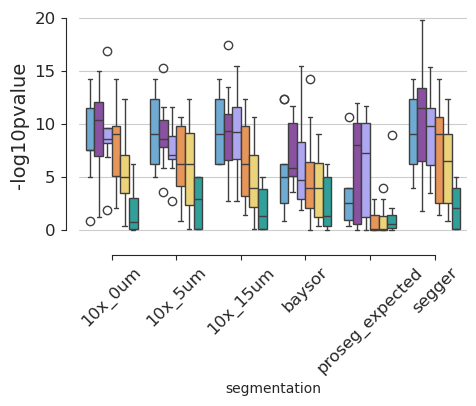

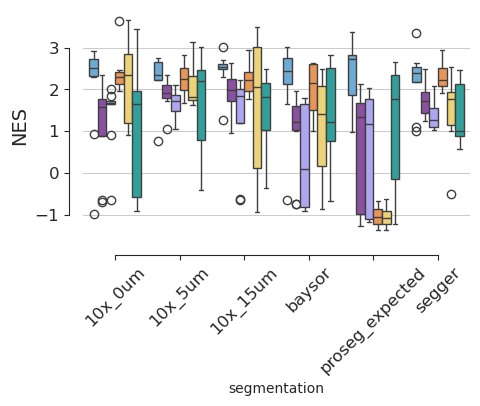

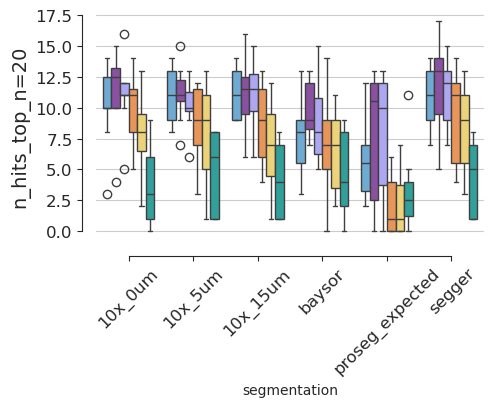

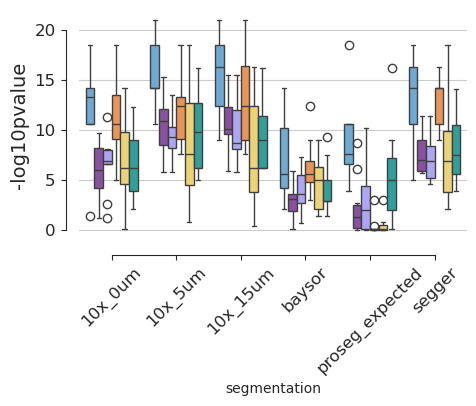

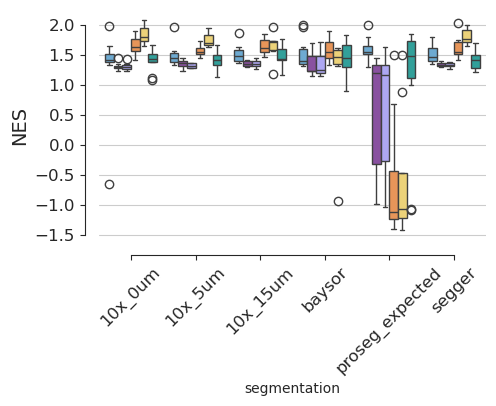

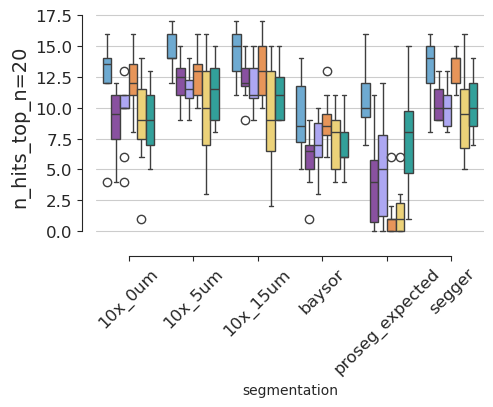

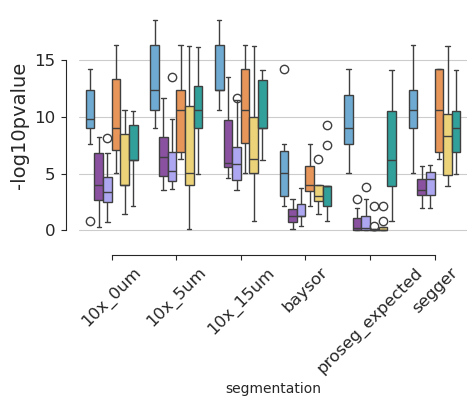

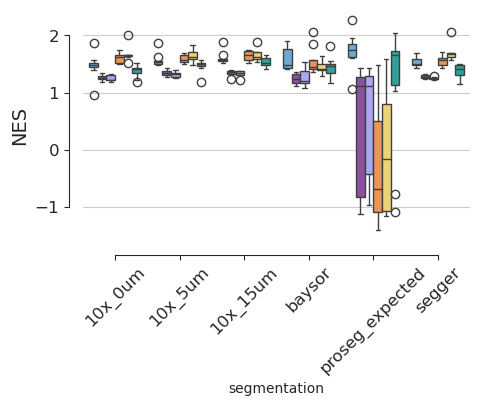

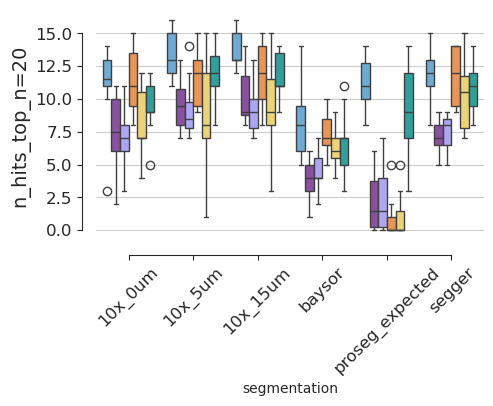

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


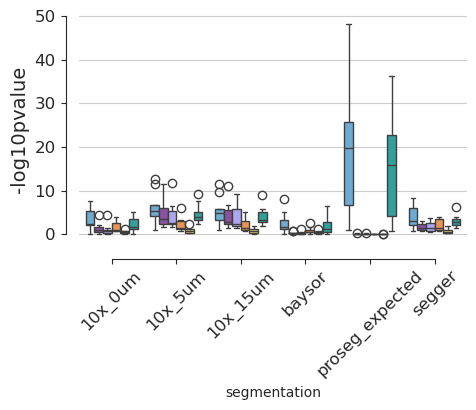

In [ ]:
condition = 'NSCLC'
panel = 'lung'
ref_cti = 'T cell'
ref_ctj = 'malignant cell'
use_precomputed = True

df_count_correction_palette = pd.read_csv(count_correction_palette, index_col=0).iloc[:, 0]

for rank_metric in rank_metrics:
    plot_metrics_ = plot_metrics[-1:] if rank_metric == "mean_zscore" else plot_metrics[:-1]
    for plot_metric in plot_metrics_:
        df = _utils.get_df_marker_rank_significance_plot(
            dfs['df_markers_rank_significance_diffexpr'],
            rank_metric=rank_metric,
            plot_metric=plot_metric,
            correction_methods=correction_methods,
            use_precomputed=use_precomputed,
        )

        if plot_metric in ["hypergeometric_pvalue", "mean_zscore_pvalue"]:
            df["-log10pvalue"] = -np.log10(df[plot_metric].astype(float))
            plot_metric = "-log10pvalue"

        df = df.query("condition == @condition and panel == @panel")

        for (cti,ctj)in df[["cti","ctj"]].drop_duplicates().values:
            if cti != ref_cti or ctj != ref_ctj:
                continue

            # out_file = out_dir / f"{panel}_{cti}_contaminated_by_{ctj}_{rank_metric}_{plot_metric}.png"

            df_plot = df.query("cti == @cti and ctj == @ctj")

            # plotting params, palette
            unique_labels = [c for c in hue_correction_order if c in np.unique(df_plot[hue_correction].dropna())]
            unique_labels = unique_labels + [
                c for c in np.unique(df_plot[hue_correction].dropna()) if c not in unique_labels
            ]
            palette = {u: df_count_correction_palette[u] for u in unique_labels}
            legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

            ### hypergeometric pvalue boxplot
            f = plt.figure(figsize=(5, 3))
            ax = plt.subplot()
            g = sns.boxplot(
                df_plot,
                x="segmentation",
                y=plot_metric,
                hue=hue_correction,
                hue_order=unique_labels,
                legend=False,
                palette=palette,
                ax=ax,
                order=[s for s in hue_segmentation_order if s in df_plot["segmentation"].unique()],
            )

            sns.despine(offset=10, trim=True)
            ax.yaxis.grid(True)
            ax.yaxis.set_tick_params(labelsize=12) # If you also want to change the y-axis numbers
            if plot_metric == '"-log10pvalue"':
                ax.set.ylabel(r'$-\log_{10} \text{ p-value}$',fontsize=14)
            else:
                ax.set_ylabel(plot_metric, fontsize=14) 
            plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12) 

            # title = f"Condition: {condition}, Panel: {panel}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}"
            # plt.suptitle(title, y=1.05)
            # f.legend(
            #     handles=legend_handles,
            #     loc="center left",
            #     bbox_to_anchor=(1, 0.5),
            #     title=hue_correction,
            #     frameon=False,
            # )
            # plt.tight_layout(rect=[0, 0, 1, 0.95])
            # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
            plt.show()

# Plot number of genes

In [ ]:
# cti = 'T cell'

# df = get_mean_n_genes(ads, correction_methods, labels_key, columns = xenium_levels + ['correction_method','mean_n_genes'])
# rename_correction_methods(df)
    
# # plotting params, palette
# title = f"Mean number of genes for {cti=}"
# unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
# unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# # palette = {u: palette[u] for u in unique_labels}
# palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
# legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# ### hypergeometric pvalue boxplot
# f = plt.figure(figsize=(6, 6))
# ax = plt.subplot()
# g = sns.boxplot(df,x='panel',y='mean_n_genes', 
#                 hue=hue_correction, hue_order=unique_labels, 
#                 legend=False, palette=palette,ax=ax,
#                 order=order
#                 )

# sns.despine(offset=10, trim=True)
# ax.yaxis.grid(True)

# plt.suptitle(title)
# f.legend(
#     handles=legend_handles,
#     loc="center left",
#     bbox_to_anchor=(1, 0.5),
#     title=hue_correction,
#     frameon=False,
# )
# # plt.tight_layout(rect=[0, 0, 1, 0.95])
# # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
# plt.show()

# Plot cell type identity score from markers

In [ ]:
cti = 'T cell'
ref_panel = 'lung'            

# get cell identity score df
df_markers = pd.read_csv(cfg['markers_dir']+'Xenium_panels_common_markers.csv',index_col=0)
df = _utils.get_mean_cell_identity_score_markers(ads, df_markers, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_marker_genes'])
_utils.rename_correction_methods(df)
df = df.query(f"panel == '{ref_panel}' and cti == '{cti}'")

# plotting params, palette
title = f"Cell type identity score for {cti=}"
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

### hypergeometric pvalue boxplot
f = plt.figure(figsize=(10, 4))
ax = plt.subplot()
g = sns.boxplot(df,x='segmentation',y='mean_n_marker_genes', 
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()]
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue_correction,
    frameon=False,
)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

# Plot cell type identity score from scRNA pseudobulk cosine similarity

In [ ]:
cti = 'T cell'
ref_panel = 'lung'        
plot_metric = 'cosine_similarity'    
palette = pd.read_csv(count_correction_palette, index_col=0).iloc[:, 0]

# get cell identity score df
df_all = _utils.get_cosine_similarity_score(pbs_xenium,pbs_scrna,labels_key,correction_methods,
    columns = xenium_levels + ['correction_method','cti','cosine_similarity']
)


_utils.rename_correction_methods(df_all)
df = df_all.query(f"panel == '{ref_panel}' and cti == '{cti}'")
    
# plotting params, palette
title = f"Cell type identity score for {cti=}"
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
palette = {u: palette[u] for u in unique_labels}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

### hypergeometric pvalue boxplot
f = plt.figure(figsize=(10, 4))
ax = plt.subplot()
g = sns.boxplot(df,x='segmentation',y=plot_metric, 
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()]
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue_correction,
    frameon=False,
)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

# Plot decontamination strength vs number of genes

In [ ]:
# params
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'

# get n_genes df
df_n_genes = get_mean_n_genes(ads, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_genes'])

# get contamination df
df_contamination = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                    for count_correction_method in correction_methods
                    for k, v in dfs['df_markers_rank_significance_diffexpr'][count_correction_method].items()
                    }).reset_index()
df_contamination.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df_contamination.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

# merge and filter for segmentation and cell type pair of interest (df_n_genes is only cti specific)
df = pd.merge(df_n_genes,df_contamination,on=xenium_levels+['cti','correction_method'])
df = df.query("segmentation == @ref_segmentation and cti == @cti and ctj == @ctj")
_utils.rename_correction_methods(df)

# Convert p-values to -log10 scale
if plot_metric == 'hypergeometric_pvalue':
    df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float)) 
    plot_metric = '-log10pvalue'

# Plot title
title = (f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n"
         f"{cti} contaminated by {ctj}\n Rank metric: {rank_metric}, Plot metric: {plot_metric}")

# Get unique labels for hue
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels += [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]

# Generate color palette
palette = dict(zip(unique_labels, sns.color_palette("hls", len(unique_labels))))

# Create legend handles for colors
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Define FacetGrid with `panel` as row-wise separation
g = sns.FacetGrid(df, col="panel", col_wrap=2, height=5, sharex=True, sharey=True)

# Add scatter plots to each facet
g.map_dataframe(sns.scatterplot, x="mean_n_genes", y=plot_metric, hue=hue_correction, palette=palette, s=100, alpha=0.6)

# Adjust legend placement
g.add_legend(title=hue_correction, frameon=False)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle(title)

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, 0.95])

# Show plot
plt.show()


# Plot cell type identity score vs number of genes

In [ ]:
# params
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'
plot_metric = 'mean_n_marker_genes'

# get n_genes df
df_n_genes = _utils.get_mean_n_genes(ads, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_genes'])

# get cell identity score df
df_markers = pd.read_csv(cfg['markers_dir']+'Xenium_panels_common_markers.csv',index_col=0)
df_cell_identity_score = _utils.get_mean_cell_identity_score_markers(ads, df_markers, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_marker_genes'])

# merge and filter for segmentation and cell type pair of interest (df_cell_identity_score is only cti specific)
df = pd.merge(df_n_genes,df_cell_identity_score,on=xenium_levels+['cti','correction_method'])
df = df.query("segmentation == @ref_segmentation and cti == @cti")
_utils.rename_correction_methods(df)

# Convert p-values to -log10 scale
if plot_metric == 'hypergeometric_pvalue':
    df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
    plot_metric = '-log10pvalue'

# Plot title
title = (f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n"
         f"{cti} contaminated by {ctj}\n")

# Get unique labels for hue
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels += [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]

# Generate color palette
palette = dict(zip(unique_labels, sns.color_palette("hls", len(unique_labels))))

# Create legend handles for colors
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Define FacetGrid with `panel` as row-wise separation
g = sns.FacetGrid(df, col="panel", col_wrap=2, height=5, sharex=True, sharey=True)

# Add scatter plots to each facet
g.map_dataframe(sns.scatterplot, x="mean_n_genes", y=plot_metric, hue=hue_correction, palette=palette, s=100, alpha=0.6)

# Adjust legend placement
g.add_legend(title=hue_correction, frameon=False)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle(title)

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, 0.95])

# Show plot
plt.show()


# Plot cell type identity score vs contamination score

In [ ]:
# params
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'
plot_metric = plot_metrics[-1]

# get cell identity score df
df_markers = pd.read_csv(cfg['markers_dir']+'Xenium_panels_common_markers.csv',index_col=0)
df_cell_identity_score = _utils.get_mean_cell_identity_score(ads, df_markers, correction_methods, labels_key, columns = xenium_levels + ['correction_method','cti','mean_n_marker_genes'])

# get contamination df
df_contamination = pd.concat({(count_correction_method,*k): v.loc[rank_metric,v.columns.get_level_values(2)==plot_metric] 
                    for count_correction_method in correction_methods
                    for k, v in dfs['df_markers_rank_significance_diffexpr'][count_correction_method].items()
                    }).reset_index()
df_contamination.columns = ['correction_method'] + xenium_levels + ["cti","ctj"] + df_contamination.columns[len(xenium_levels)+3 :-1].tolist() + [plot_metric]

# merge and filter for segmentation and cell type pair of interest (df_n_genes is only cti specific)
df = pd.merge(df_cell_identity_score,df_contamination,on=xenium_levels+['cti','correction_method'])
df = df.query("panel == @ref_panel and cti == @cti and ctj == @ctj")
_utils.rename_correction_methods(df)

# Convert p-values to -log10 scale
if plot_metric == 'hypergeometric_pvalue':
    df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
    plot_metric = '-log10pvalue'

# Plot title
title = (f"Segmentation: {ref_segmentation}, Reference: {reference}, Method: {method}, Level: {level} \n"
         f"{cti} contaminated by {ctj}\n")

# Get unique labels for hue
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels += [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]

# Generate color palette
palette = dict(zip(unique_labels, sns.color_palette("hls", len(unique_labels))))

# Create legend handles for colors
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Define FacetGrid with `panel` as row-wise separation
g = sns.FacetGrid(df, col="panel", col_wrap=2, height=5, sharex=True, sharey=True)

# Add scatter plots to each facet
g.map_dataframe(sns.scatterplot, x="mean_n_marker_genes", y=plot_metric, hue=hue_correction, palette=palette, s=100, alpha=0.6)

# Adjust legend placement
g.add_legend(title=hue_correction, frameon=False)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle(title)

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, 0.95])

# Show plot
plt.show()


# Summary metrics

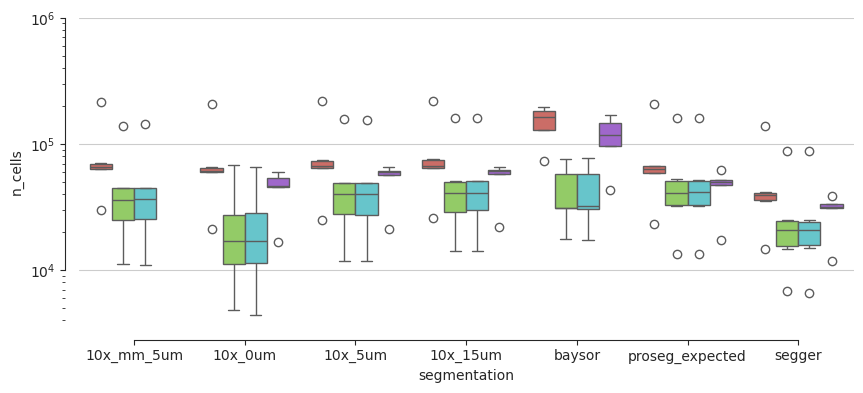

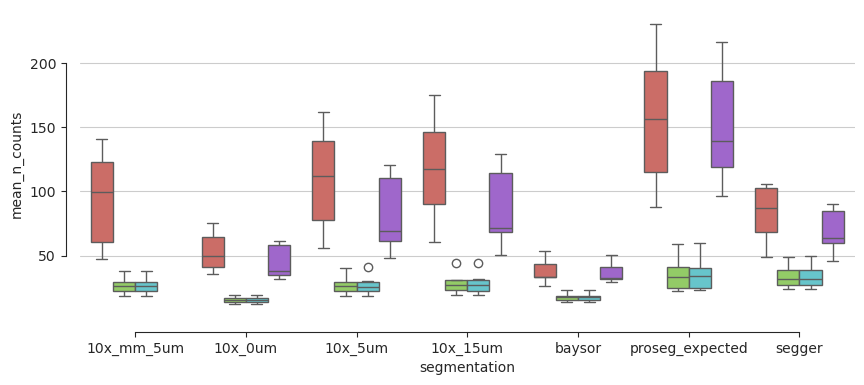

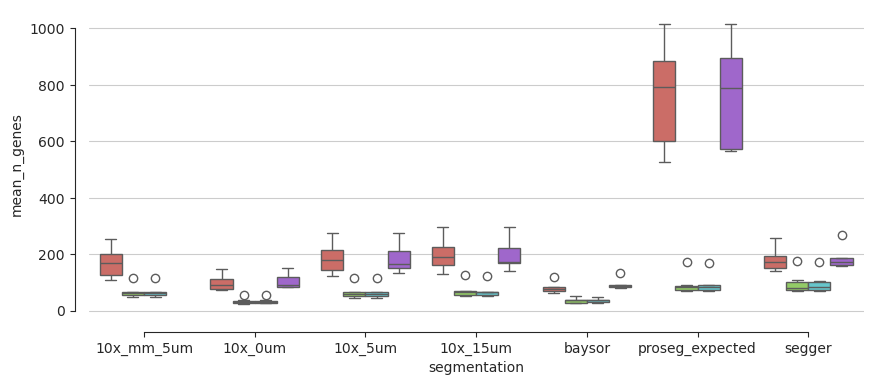

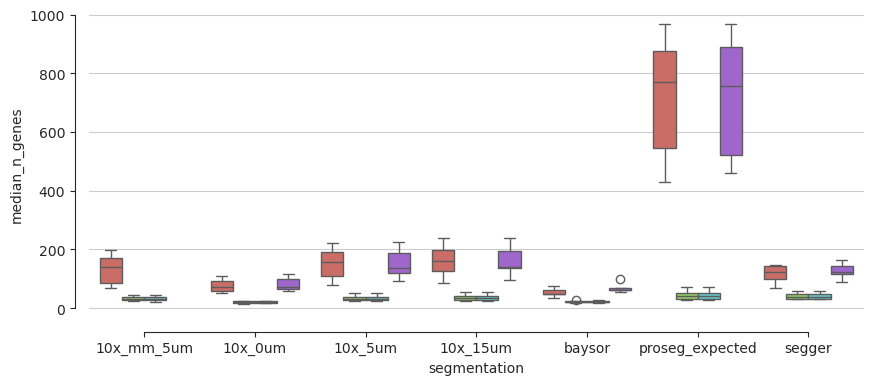

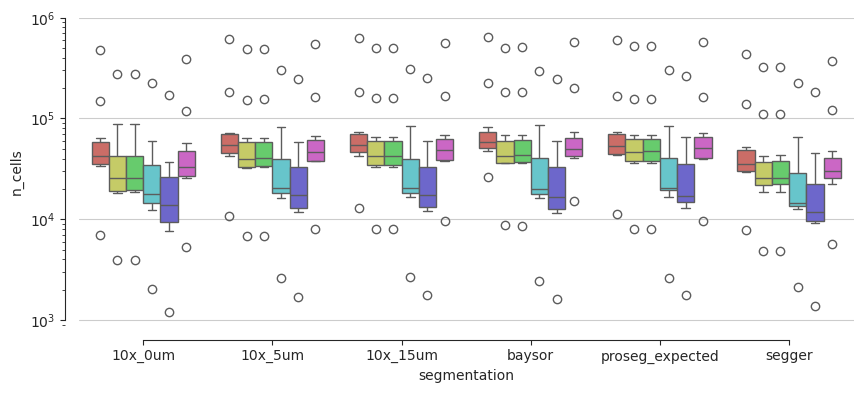

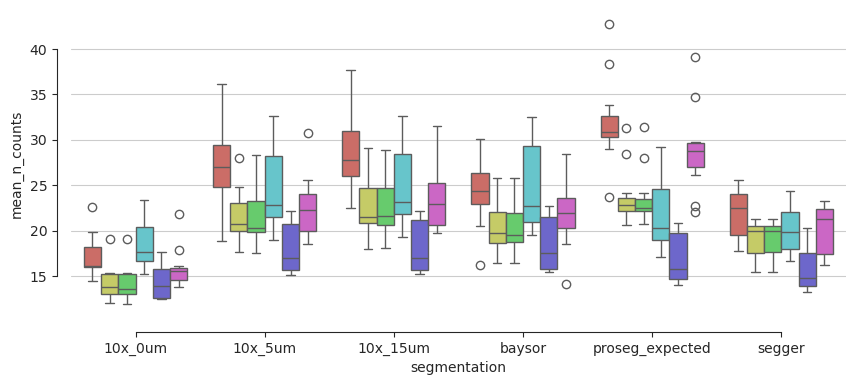

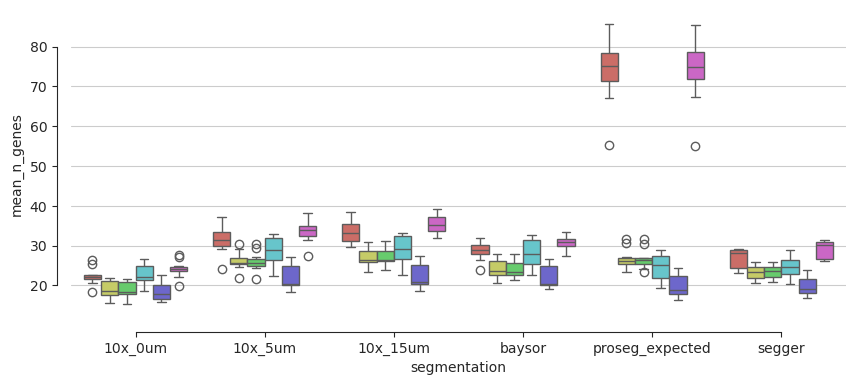

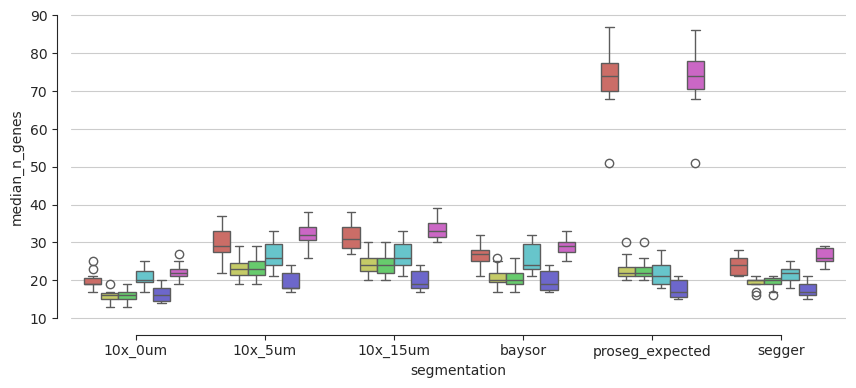

In [5]:
ref_panels = ['5k','lung']
plot_metrics = ['n_cells','mean_n_counts','mean_n_genes','median_n_genes']

for ref_panel in ref_panels:
    for plot_metric in plot_metrics:

        df = _utils.get_df_summary_stats_plot(dfs,plot_metric=plot_metric)
        df = df.query("panel == @ref_panel")

        # plotting params, palette
        title = f"{plot_metric} for {ref_panel}"
        unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
        # palette = {u: palette[u] for u in unique_labels}
        palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        ###  boxplot
        f = plt.figure(figsize=(10, 4))
        ax = plt.subplot()
        g = sns.boxplot(df,x='segmentation',y=plot_metric, 
                        hue=hue_correction, hue_order=unique_labels, 
                        legend=False, palette=palette,ax=ax,
                        order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()],
                        log_scale=True if plot_metric == 'n_cells' else False,
                        showfliers=True
                        )

        if plot_metric == 'n_cells':
            ax.set_ylim(None,1e6)
        sns.despine(offset=10, trim=True)
        ax.yaxis.grid(True)

        # plt.suptitle(title)
        # f.legend(
        #     handles=legend_handles,
        #     loc="center left",
        #     bbox_to_anchor=(1, 0.5),
        #     title=hue_correction,
        #     frameon=False,
        # )

In [ ]:
ref_panel = 'lung'
ref_segmentation = '10x_5um'
plot_metrics = ['n_cells_by_type','mean_n_genes_by_type','median_n_genes_by_type']

for plot_metric in plot_metrics:

    df = _utils.get_df_summary_stats_plot(dfs,plot_metric=plot_metric)
    df = df.query("panel == @ref_panel and segmentation == @ref_segmentation")

    # plotting params, palette
    title = f"{plot_metric} for {ref_panel} {ref_segmentation}"
    unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
    # palette = {u: palette[u] for u in unique_labels}
    palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
    legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

    ###  boxplot
    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot()
    g = sns.boxplot(df,x=plot_metric+'_key',y=plot_metric+'_value', 
                    hue=hue_correction, hue_order=unique_labels, 
                    legend=False, palette=palette,ax=ax,
                    # order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()],
                    log_scale=True if plot_metric == 'n_cells_by_type' else False,
                    showfliers=True
                    )

    sns.despine(offset=10, trim=True)
    ax.yaxis.grid(True)
    plt.xticks(rotation=45, ha='right')

    plt.suptitle(title)
    f.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=hue_correction,
        frameon=False,
    )

In [ ]:

cti = 'T cell'
ctj = 'malignant cell'
ref_panel = 'lung'
plot_metric = 'df_has_neighbor_counts'


df = _utils.get_df_summary_stats_plot(dfs,plot_metric=plot_metric)
df = df.query("panel == @ref_panel")

df[f'{cti}_has_{ctj}_neighbor'] = _utils.extract_info_cell_type_pair(df[plot_metric],cti,ctj,True)
df[f'{cti}_has_no_{ctj}_neighbor'] = _utils.extract_info_cell_type_pair(df[plot_metric],cti,ctj,False)

# plotting params, palette
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

###  boxplot
for y in [f'{cti}_has_{ctj}_neighbor',f'{cti}_has_no_{ctj}_neighbor']:

    title = f"{y} for {ref_panel}"

    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot()
    g = sns.boxplot(df,x='segmentation',y=y, 
                    hue=hue_correction, hue_order=unique_labels, 
                    legend=False, palette=palette,ax=ax,
                    # order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()],
                    log_scale=True,
                    showfliers=True
                    )

    sns.despine(offset=10, trim=True)
    ax.yaxis.grid(True)
    plt.xticks(rotation=45, ha='right')

    plt.suptitle(title)
    f.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=hue_correction,
        frameon=False,
    )

# Plot rankings

In [ ]:
def get_df_ctj_marker_genes(dfs_ctj_marker_genes, correction_methods,):
    df_ctj_marker_genes = {}
    for correction_method in correction_methods:
        for k, v in dfs['df_ctj_marker_genes'][correction_method].items():
            for ctj in v.columns:
                df_ctj_marker_genes[(correction_method,*k,ctj)] = v[ctj]

    df_ctj_marker_genes = pd.concat(df_ctj_marker_genes).reset_index().drop('level_7',axis=1)
    df_ctj_marker_genes.columns = ['correction_method'] + xenium_levels + ['cell_type','gene']
    return df_ctj_marker_genes


df_ctj_marker_genes = get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
cti = 'T cell'
ctj = 'malignant cell'
malignant_markers = df_ctj_marker_genes.query("cell_type == @ctj and correction_method == 'raw' and segmentation == '10x_5um'")['gene'].value_counts()[:20].index
t_cell_markers = df_ctj_marker_genes.query("cell_type == @cti and correction_method == 'raw' and segmentation == '10x_5um'")['gene'].value_counts()[:20].index

In [ ]:
cti = 'T cell'
ctj = 'malignant cell'
ref_panel = 'lung'
# ref_segmentation = '10x_5um'
rank_metric = rank_metrics[-3]
df = {}
for correction_method in correction_methods:
    for k, v in dfs['df_diffexpr'][correction_method].items():
        if k[2] != ref_panel:
            continue
        # for (cti,ctj) in v.index.droplevel(2).unique():
        if (cti,ctj) in v.index:
            df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index('names').loc[:,rank_metric]

df = pd.DataFrame(df).T.reset_index()
df.columns = ["correction_method"] + xenium_levels + ["cti", "ctj"] + df.columns[8:].tolist()
_utils.rename_correction_methods(df)

# df = df.query("segmentation == @ref_segmentation and panel == @ref_panel and cti == @cti and ctj == @ctj")
# df = df.iloc[:,8:]
df_norm = df.copy()
df_norm.iloc[:,8:] =  df.iloc[:,8:].div(df.iloc[:,8:].abs().sum(axis=1),axis=0)

In [ ]:
df_labeling_info = pd.DataFrame(columns=['Gene', 'Label'])
df_labeling_info['Gene'] = df_norm.columns[8:]
df_labeling_info['Label'] = 'unknown'

ctj_markers = [g for g in malignant_markers if g in df_labeling_info.Gene.values]
cti_markers = [g for g in t_cell_markers if g in df_labeling_info.Gene.values]
df_labeling_info.loc[df_labeling_info['Gene'].isin(ctj_markers), 'Label'] = 'malignant cell'
df_labeling_info.loc[df_labeling_info['Gene'].isin(cti_markers), 'Label'] = 'T cell'
df_labeling_info = df_labeling_info.query("Label != 'unknown'")

# --- Prepare Labeling Info ---
# Create a dictionary for quick lookup: Gene -> Label
gene_to_label = pd.Series(df_labeling_info.Label.values, index=df_labeling_info.Gene).to_dict()

# Define a color palette for the labels (important for consistency)
unique_labels = df_labeling_info['Label'].unique()
# Using a predefined qualitative palette like 'tab10' or 'Set3'
# Ensure enough colors for your labels
palette_name = 'tab10' # Or 'Set3', 'Paired', etc.
colors = sns.color_palette(palette_name, n_colors=len(unique_labels))
label_palette = dict(zip(unique_labels, colors))


# --- Identify metadata and importance (gene) columns in df_norm ---
# Assuming importance columns start after 'ctj' or are non-metadata
metadata_cols = ['correction_method', 'segmentation', 'condition', 'panel', 'donor', 'sample', 'cti', 'ctj']
# Filter out metadata columns that might not be present in all user DFs
metadata_cols_present = [col for col in metadata_cols if col in df_norm.columns]
importance_cols = df_norm.columns.difference(metadata_cols_present, sort=False).tolist()

segmentations = [h for h in hue_segmentation_order if h in df_norm['segmentation'].unique()]
for segmentation in segmentations:
    # --- Get unique combinations of grouping variables ---
    groups = [[g,segmentation] for g in hue_correction_order]
    num_groups = len(groups)

    # --- Setup Subplots ---

    ncols = num_groups
    nrows = 1

    base_width_per_plot = 3  # Adjust as needed
    base_height_per_plot = 7 # Taller for vertical plots with rotated labels
    fig_width = base_width_per_plot * ncols
    fig_height = base_height_per_plot * nrows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height),squeeze=False) # Ensure axes is always 2D
    axes_flat = axes.flatten()

    # --- Generate plot for each group ---
    plot_handles, plot_labels = [], [] # To collect handles/labels for a single legend

    for i, group_vals in enumerate(groups):
        correction_method, segmentation = group_vals
        ax = axes_flat[i]

        # 1. Filter df_norm for the current group
        group_df = df_norm[
            (df_norm['correction_method'] == correction_method) &
            (df_norm['segmentation'] == segmentation)
        ].copy() # Use .copy() to avoid SettingWithCopyWarning later
    
        group_importances = group_df[importance_cols]
        mean_importances = group_importances.median(axis=0).dropna()
        n_top = min(40, len(mean_importances))
        top_genes = mean_importances.nlargest(n_top).index.tolist()
        # top_genes = df_labeling_info['Gene'].values

        # 3. Prepare data for plotting: Melt and Add Labels
        # Ensure only top genes are selected *before* melting
        melt_data = group_df[top_genes]
        plot_data_long = melt_data.melt(
            var_name='Gene',
            value_name='Importance'
        )

        # **** Add the 'Label' column for coloring ****
        plot_data_long['Label'] = plot_data_long['Gene'].map(gene_to_label)
        # Handle genes that might be missing a label
        plot_data_long['Label'] = plot_data_long['Label'].fillna('Unknown')
        # Ensure 'Unknown' has a color if it arises
        if 'Unknown' not in label_palette and 'Unknown' in plot_data_long['Label'].unique():
                label_palette['Unknown'] = '#808080' # Add grey for unknown

        # Check if any labels were actually assigned
        hue_param = 'Label'
        palette_param = label_palette

        sns.boxplot(
            data=plot_data_long,
            x='Importance',          # Genes on X-axis -> Vertical boxes
            y='Gene',    # Values on Y-axis
            hue=hue_param,     # Color by the 'Label' column
            order=top_genes,   # Order genes by mean importance
            palette=palette_param, # Use the defined label-color mapping
            dodge=False,       # Don't shift boxes for hue, color the whole box
            ax=ax,             # Draw on the correct subplot axis
            fliersize=1.5,
            log_scale = True
        )

        # 5. Customize the SUBPLOT
        ax.set_title(f'{correction_method}\n{segmentation}', fontsize=10)
        # ax.tick_params(axis='x', rotation=90, labelsize=8)
        # ax.tick_params(axis='y', labelsize=8)
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        ax.axvline(0.0, color='k', linestyle='-', zorder=-1, alpha=0.5)
        ax.set_xlabel(rank_metric, fontsize=9)

        if i % ncols == 0:
            ax.set_ylabel('Gene', fontsize=9)
        else:
            ax.set_ylabel('')

        # Remove individual subplot legends if hue was used (will create one below)
        if hue_param:
                # Collect handles/labels from the first plot that has a legend
                if not plot_labels and ax.get_legend() is not None:
                    handles, labels = ax.get_legend_handles_labels()
                    # Use a dictionary to ensure unique labels/handles
                    unique_hl = dict(zip(labels, handles))
                    plot_handles = list(unique_hl.values())
                    plot_labels = list(unique_hl.keys())

                if ax.get_legend() is not None:
                    ax.get_legend().remove()


    # --- Final Plot Adjustments ---
    # Hide unused subplots
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    # Add a single legend for the whole figure if labels were used
    if plot_labels:
        # Adjust legend position: place it outside the top right corner
        fig.legend(handles=plot_handles, labels=plot_labels, title="Gene Label",
                    bbox_to_anchor=(.94, 0.5), loc='upper left', fontsize=9, title_fontsize=10)

    # plt.suptitle('Top 20 Feature Importances per Condition', fontsize=16, y=.95)
    # Adjust layout carefully to make space for suptitle and potential legend
    fig.tight_layout(rect=[0, 0.03, 0.95, 0.95]) # Adjust right margin for legend if needed (e.g., 0.9 or 0.85)
    plt.show()